In [37]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import cv2
from tqdm.notebook import tqdm
from sklearn.metrics import f1_score, jaccard_score
import yaml
import random
from PIL import Image

# Set seed for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed()

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load configuration
def load_config(config_path="square_segmentation_dataset/config.yaml"):
    with open(config_path, 'r') as f:
        config = yaml.safe_load(f)
    return config

# Load dataset configuration
dataset_config = load_config()
print("Dataset configuration loaded!")

Using device: cuda
Dataset configuration loaded!


In [38]:
class SquareSegmentationDataset(Dataset):
    def __init__(self, data_dir, split='train', transform=None):
        self.data_dir = data_dir
        self.split = split
        self.transform = transform
        
        # Get image and mask paths
        self.image_dir = os.path.join(data_dir, split, 'images')
        self.mask_dir = os.path.join(data_dir, split, 'masks')
        
        self.image_paths = sorted([os.path.join(self.image_dir, img) 
                                  for img in os.listdir(self.image_dir)
                                  if img.endswith('.png')])
        
        self.mask_paths = sorted([os.path.join(self.mask_dir, mask) 
                                 for mask in os.listdir(self.mask_dir)
                                 if mask.endswith('.png')])
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        # Load image and mask
        image = cv2.imread(self.image_paths[idx], cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(self.mask_paths[idx], cv2.IMREAD_GRAYSCALE)
        
        # Normalize image and mask
        image = image / 255.0
        mask = (mask > 128).astype(np.float32)  # Convert to binary mask
        
        # Convert to tensor
        image = torch.from_numpy(image).float().unsqueeze(0)  # Add channel dimension
        mask = torch.from_numpy(mask).float().unsqueeze(0)    # Add channel dimension
        
        # Apply transformations if any
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
            
        return image, mask


Train samples: 210
Validation samples: 45
Test samples: 45
Training samples:


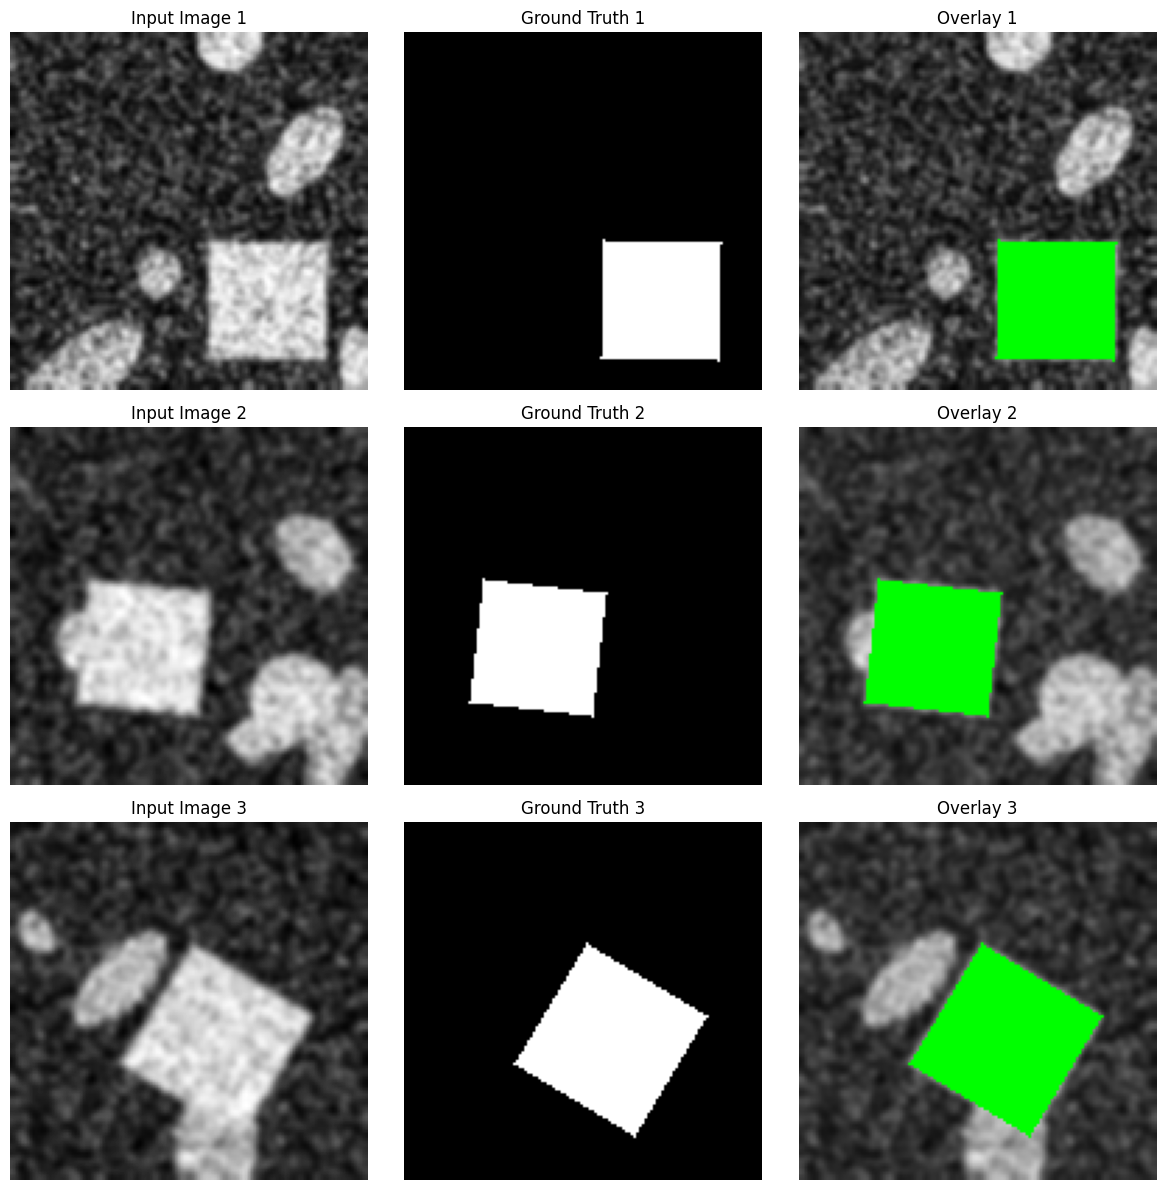

In [39]:
# Create dataloaders
def get_dataloaders(data_dir, batch_size=8, num_workers=0):  # Setting num_workers=0 for Windows compatibility
    train_dataset = SquareSegmentationDataset(data_dir, split='train')
    val_dataset = SquareSegmentationDataset(data_dir, split='val')
    test_dataset = SquareSegmentationDataset(data_dir, split='test')
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, 
                             num_workers=num_workers, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, 
                           num_workers=num_workers, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,
                            num_workers=num_workers, pin_memory=True)
    
    return train_loader, val_loader, test_loader

# Initialize dataloaders
data_dir = dataset_config['dataset']['path']
train_loader, val_loader, test_loader = get_dataloaders(data_dir)

# Display dataset sizes
print(f"Train samples: {len(train_loader.dataset)}")
print(f"Validation samples: {len(val_loader.dataset)}")
print(f"Test samples: {len(test_loader.dataset)}")

# Visualize some samples
def visualize_samples(dataloader, num_samples=3):
    # Get a batch of samples
    images, masks = next(iter(dataloader))
    
    fig, axes = plt.subplots(num_samples, 3, figsize=(12, 4 * num_samples))
    
    for i in range(min(num_samples, len(images))):
        # Get image and mask
        image = images[i, 0].numpy()
        mask = masks[i, 0].numpy()
        
        # Display image
        axes[i, 0].imshow(image, cmap='gray')
        axes[i, 0].set_title(f"Input Image {i+1}")
        axes[i, 0].axis('off')
        
        # Display mask
        axes[i, 1].imshow(mask, cmap='gray')
        axes[i, 1].set_title(f"Ground Truth {i+1}")
        axes[i, 1].axis('off')
        
        # Display overlay
        overlay = np.zeros((image.shape[0], image.shape[1], 3))
        overlay[..., 0] = image
        overlay[..., 1] = image
        overlay[..., 2] = image
        overlay[mask > 0.5, 0] = 0
        overlay[mask > 0.5, 1] = 1
        overlay[mask > 0.5, 2] = 0
        
        axes[i, 2].imshow(overlay)
        axes[i, 2].set_title(f"Overlay {i+1}")
        axes[i, 2].axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize training samples
print("Training samples:")
visualize_samples(train_loader)

In [40]:
# Define Mini U-Net Model
class DoubleConv(nn.Module):
    """Double convolution block for U-Net."""
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    """Downscaling block for U-Net."""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    """Upscaling block for U-Net."""
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        
        # if bilinear, use a simple upsampling followed by a conv, else use transpose conv
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            # Note: in_channels is the concatenated channels from skip connection + upsampled
            self.conv = DoubleConv(in_channels, out_channels)
        else:
            self.up = nn.ConvTranspose2d(in_channels // 2, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        
        # Pad x1 if needed (ensure dimensions match)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                       diffY // 2, diffY - diffY // 2])
        
        # Concatenate along channel dimension
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    """Final convolution layer for U-Net."""
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class MiniUNet(nn.Module):
    """A lightweight U-Net model for segmentation."""
    def __init__(self, n_channels=1, n_classes=1, base_filters=16, bilinear=True, depth=3):
        super(MiniUNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear
        self.depth = depth
        
        # Initial double convolution
        self.inc = DoubleConv(n_channels, base_filters)
        
        # Downsampling path
        self.down_path = nn.ModuleList()
        
        # Store feature map sizes for skip connections
        self.feature_channels = [base_filters]
        
        # Create downsampling blocks
        in_channels = base_filters
        for i in range(depth):
            out_channels = in_channels * 2
            self.down_path.append(Down(in_channels, out_channels))
            self.feature_channels.append(out_channels)
            in_channels = out_channels
        
        # Upsampling path
        self.up_path = nn.ModuleList()
        
        # Create upsampling blocks
        for i in range(depth):
            # Get input channels for upsampling block
            in_features = self.feature_channels[-(i+1)]
            out_features = self.feature_channels[-(i+2)]
            
            # Total channels after concatenation
            total_channels = in_features + out_features
            
            self.up_path.append(Up(total_channels, out_features, bilinear))
        
        # Final convolution
        self.outc = OutConv(base_filters, n_classes)

    def forward(self, x):
        # Initial feature extraction
        x1 = self.inc(x)
        
        # Downsampling path - save skip connections
        skip_connections = [x1]
        x_down = x1
        
        for down in self.down_path:
            x_down = down(x_down)
            skip_connections.append(x_down)
        
        # Remove the last feature map from skip connections - it's the bottleneck
        x_up = skip_connections.pop()
        
        # Upsampling path - use skip connections
        for up in self.up_path:
            x2 = skip_connections.pop()
            x_up = up(x_up, x2)
        
        # Final convolution
        logits = self.outc(x_up)
        
        return logits

# Initialize model
def get_model(model_config):
    model = MiniUNet(
        n_channels=1,  # Grayscale input
        n_classes=1,   # Binary segmentation (square vs background)
        base_filters=model_config.get('base_filters', 16),
        bilinear=model_config.get('bilinear', True),
        depth=model_config.get('depth', 3)
    )
    return model.to(device)

# Test the model with a random input
def test_model(model, input_size=(1, 1, 128, 128)):
    x = torch.randn(input_size).to(device)
    with torch.no_grad():
        output = model(x)
    print(f"Input shape: {x.shape}")
    print(f"Output shape: {output.shape}")
    
    # Calculate total parameters
    total_params = sum(p.numel() for p in model.parameters())
    print(f"Total parameters: {total_params:,}")
    
    return output.shape

# Define model configuration
model_config = {
    'base_filters': 16,
    'bilinear': True,
    'depth': 3
}

# Initialize and test model
model = get_model(model_config)
test_model(model)

Input shape: torch.Size([1, 1, 128, 128])
Output shape: torch.Size([1, 1, 128, 128])
Total parameters: 487,713


torch.Size([1, 1, 128, 128])

In [41]:
# Define loss function and evaluation metrics
class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super(DiceLoss, self).__init__()
        self.smooth = smooth
        
    def forward(self, pred, target):
        # Flatten predictions and targets
        pred = pred.view(-1)
        target = target.view(-1)
        
        # Calculate Dice coefficient
        intersection = (pred * target).sum()
        dice = (2. * intersection + self.smooth) / (pred.sum() + target.sum() + self.smooth)
        
        # Return Dice loss
        return 1 - dice

def binary_accuracy(pred, target, threshold=0.5):
    """Calculate binary accuracy."""
    pred_binary = (pred > threshold).float()
    correct = (pred_binary == target).float().sum()
    acc = correct / target.numel()
    return acc.item()

def calculate_metrics(pred, target, threshold=0.5):
    """Calculate segmentation metrics."""
    pred_np = (pred.squeeze() > threshold).cpu().numpy().flatten()
    target_np = target.squeeze().cpu().numpy().flatten()
    
    # Calculate F1 score and IoU
    f1 = f1_score(target_np, pred_np, zero_division=1)
    iou = jaccard_score(target_np, pred_np, zero_division=1)
    
    return {
        'f1_score': f1,
        'iou_score': iou
    }

In [ ]:
# Define training and evaluation functions
def train_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    running_acc = 0.0
    
    # Use simple iteration with a progress counter
    for _, (images, masks) in enumerate(dataloader):
        # Move data to device
        images = images.to(device)
        masks = masks.to(device)
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images)
        
        # Apply sigmoid activation
        outputs = torch.sigmoid(outputs)
        
        # Calculate loss
        loss = criterion(outputs, masks)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Update metrics
        running_loss += loss.item() * images.size(0)
        running_acc += binary_accuracy(outputs, masks) * images.size(0)
        
    # Calculate epoch metrics
    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = running_acc / len(dataloader.dataset)
    
    return epoch_loss, epoch_acc

def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_acc = 0.0
    all_metrics = {
        'f1_score': 0.0,
        'iou_score': 0.0
    }
    
    # Use simple iteration with a progress counter
    with torch.no_grad():
        for _, (images, masks) in enumerate(dataloader):
            # Move data to device
            images = images.to(device)
            masks = masks.to(device)
            
            # Forward pass
            outputs = model(images)
            
            # Apply sigmoid activation
            outputs = torch.sigmoid(outputs)
            
            # Calculate loss
            loss = criterion(outputs, masks)
            
            # Update metrics
            running_loss += loss.item() * images.size(0)
            running_acc += binary_accuracy(outputs, masks) * images.size(0)
            
            # Calculate additional metrics
            batch_metrics = calculate_metrics(outputs, masks)
            for k, v in batch_metrics.items():
                all_metrics[k] += v * images.size(0)
        
    # Calculate average metrics
    metrics = {
        'loss': running_loss / len(dataloader.dataset),
        'accuracy': running_acc / len(dataloader.dataset)
    }
    
    # Add additional metrics
    for k, v in all_metrics.items():
        metrics[k] = v / len(dataloader.dataset)
    
    return metrics

# Define function to train model with fixed hyperparameters
def train_model(model, train_loader, val_loader, optimizer, criterion, 
                scheduler=None, num_epochs=50, patience=10):
    
    # Initialize history dictionary
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': [],
        'val_f1': [],
        'val_iou': []
    }
    
    # Initialize best metrics and early stopping variables
    best_val_loss = float('inf')
    best_model_state = None
    counter = 0
    
    # Training loop
    for epoch in range(num_epochs):
        # Train for one epoch
        train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, device)
        
        # Evaluate on validation set
        val_metrics = evaluate(model, val_loader, criterion, device)
        
        # Update learning rate if scheduler is provided
        if scheduler is not None:
            scheduler.step(val_metrics['loss'])
        
        # Print progress
        if (epoch + 1) % 5 == 0 or epoch == num_epochs - 1:
            print(f"Epoch [{epoch+1}/{num_epochs}] - Train loss: {train_loss:.4f} - Train acc: {train_acc:.4f} - Val loss: {val_metrics['loss']:.4f} - Val acc: {val_metrics['accuracy']:.4f} - Val F1: {val_metrics['f1_score']:.4f} - Val IoU: {val_metrics['iou_score']:.4f}")
        
        # Update history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_metrics['loss'])
        history['val_acc'].append(val_metrics['accuracy'])
        history['val_f1'].append(val_metrics['f1_score'])
        history['val_iou'].append(val_metrics['iou_score'])
        
        # Check for improvement
        if val_metrics['loss'] < best_val_loss:
            best_val_loss = val_metrics['loss']
            best_model_state = model.state_dict().copy()
            counter = 0
        else:
            counter += 1
        
        # Early stopping
        if counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs")
            break
    
    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    return model, history

# Define training configuration
train_config = {
    'learning_rate': 0.0005,
    'weight_decay': 1e-5,
    'batch_size': 16,
    'num_epochs': 50,
    'patience': 10
}

# Initialize optimizer, loss and scheduler
model = get_model(model_config)
criterion = DiceLoss()
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=train_config['learning_rate'],
    weight_decay=train_config['weight_decay']
)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5, verbose=True
)

# Train model
print("Starting training...")
model, history = train_model(
    model, train_loader, val_loader, optimizer, criterion,
    scheduler=scheduler, 
    num_epochs=train_config['num_epochs'],
    patience=train_config['patience']
)

c:\Users\joewh\miniconda3\envs\stitch-o\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Starting training...
Epoch [5/50] - Train loss: 0.4489 - Train acc: 0.9607 - Val loss: 0.5291 - Val acc: 0.8946 - Val F1: 0.5555 - Val IoU: 0.3891
Epoch [10/50] - Train loss: 0.2190 - Train acc: 0.9685 - Val loss: 0.1798 - Val acc: 0.9676 - Val F1: 0.9118 - Val IoU: 0.8391
Epoch [15/50] - Train loss: 0.1133 - Train acc: 0.9780 - Val loss: 0.9484 - Val acc: 0.8293 - Val F1: 0.0001 - Val IoU: 0.0000
Epoch [20/50] - Train loss: 0.0834 - Train acc: 0.9803 - Val loss: 0.0770 - Val acc: 0.9810 - Val F1: 0.9436 - Val IoU: 0.8947
Epoch [25/50] - Train loss: 0.0769 - Train acc: 0.9806 - Val loss: 0.0651 - Val acc: 0.9809 - Val F1: 0.9432 - Val IoU: 0.8936
Epoch [30/50] - Train loss: 0.0516 - Train acc: 0.9869 - Val loss: 0.0433 - Val acc: 0.9877 - Val F1: 0.9632 - Val IoU: 0.9295
Epoch [35/50] - Train loss: 0.0451 - Train acc: 0.9888 - Val loss: 0.0434 - Val acc: 0.9873 - Val F1: 0.9620 - Val IoU: 0.9274
Epoch [40/50] - Train loss: 0.0391 - Train acc: 0.9905 - Val loss: 0.0551 - Val acc: 0.9823

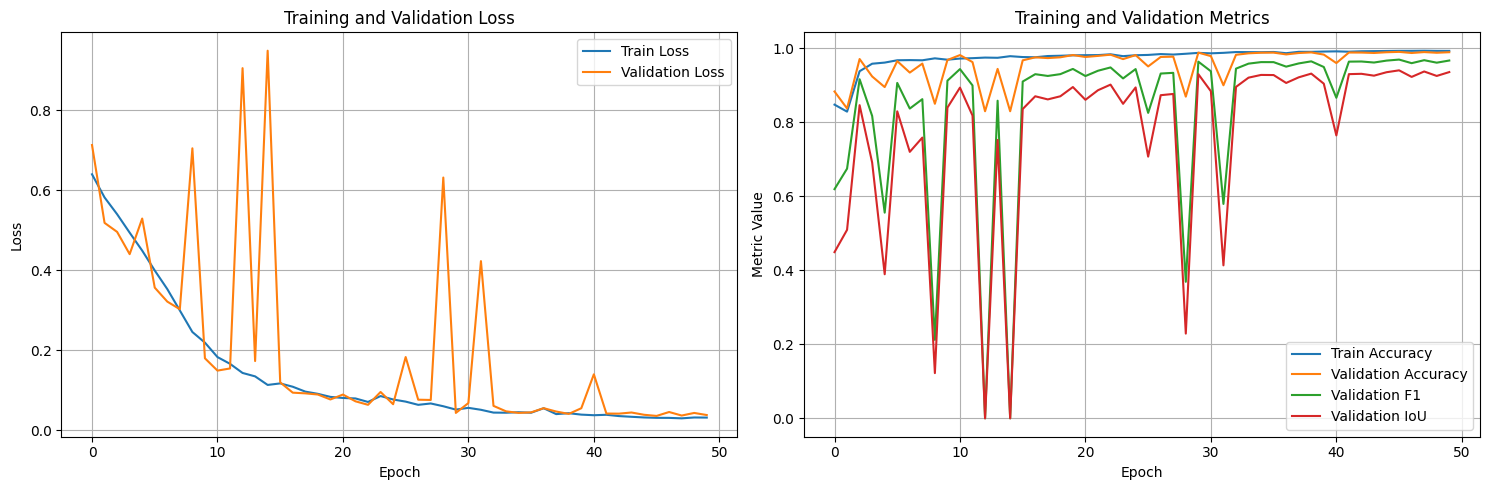

In [47]:
# Plot training history
def plot_history(history):
    # Create figure with 2 subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot losses
    ax1.plot(history['train_loss'], label='Train Loss')
    ax1.plot(history['val_loss'], label='Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.legend()
    ax1.grid(True)
    
    # Plot metrics
    ax2.plot(history['train_acc'], label='Train Accuracy')
    ax2.plot(history['val_acc'], label='Validation Accuracy')
    ax2.plot(history['val_f1'], label='Validation F1')
    ax2.plot(history['val_iou'], label='Validation IoU')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Metric Value')
    ax2.set_title('Training and Validation Metrics')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

# Plot training history
plot_history(history)

Test set evaluation:
  loss: 0.0691
  accuracy: 0.9808
  f1_score: 0.9355
  iou_score: 0.8808
Predictions on test set:


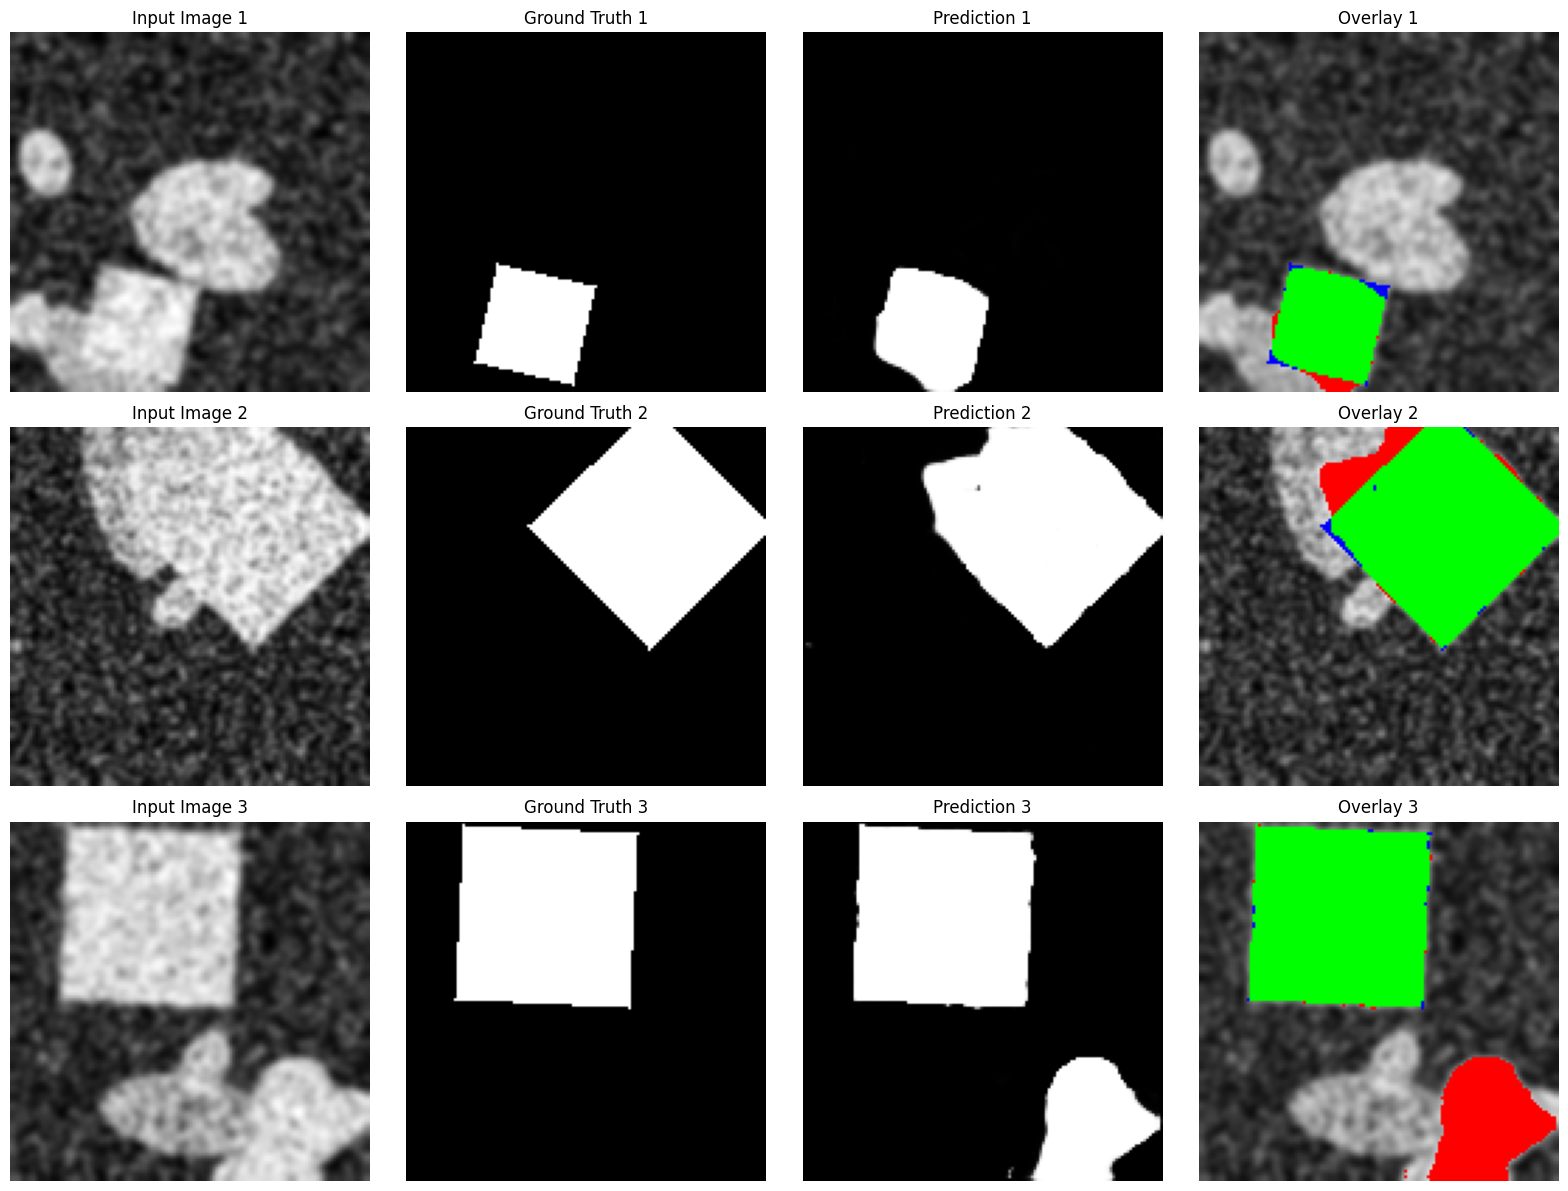

In [48]:
# Evaluate on test set
test_metrics = evaluate(model, test_loader, criterion, device)
print("Test set evaluation:")
for metric, value in test_metrics.items():
    print(f"  {metric}: {value:.4f}")

# Visualize predictions on test set
def visualize_predictions(model, dataloader, num_samples=3):
    # Get a batch of samples
    images, masks = next(iter(dataloader))
    
    # Make predictions
    model.eval()
    with torch.no_grad():
        preds = torch.sigmoid(model(images.to(device)))
    
    # Convert predictions to numpy
    preds = preds.cpu().numpy()
    
    # Create figure
    fig, axes = plt.subplots(num_samples, 4, figsize=(16, 4 * num_samples))
    
    for i in range(min(num_samples, len(images))):
        # Get image, mask and prediction
        image = images[i, 0].numpy()
        mask = masks[i, 0].numpy()
        pred = preds[i, 0]
        
        # Display image
        axes[i, 0].imshow(image, cmap='gray')
        axes[i, 0].set_title(f"Input Image {i+1}")
        axes[i, 0].axis('off')
        
        # Display ground truth
        axes[i, 1].imshow(mask, cmap='gray')
        axes[i, 1].set_title(f"Ground Truth {i+1}")
        axes[i, 1].axis('off')
        
        # Display prediction
        axes[i, 2].imshow(pred, cmap='gray')
        axes[i, 2].set_title(f"Prediction {i+1}")
        axes[i, 2].axis('off')
        
        # Display overlay
        pred_binary = (pred > 0.5).astype(np.float32)
        overlay = np.zeros((image.shape[0], image.shape[1], 3))
        overlay[..., 0] = image
        overlay[..., 1] = image
        overlay[..., 2] = image
        
        # Highlight true positives in green
        tp = (pred_binary == 1) & (mask == 1)
        overlay[tp, 0] = 0
        overlay[tp, 1] = 1
        overlay[tp, 2] = 0
        
        # Highlight false positives in red
        fp = (pred_binary == 1) & (mask == 0)
        overlay[fp, 0] = 1
        overlay[fp, 1] = 0
        overlay[fp, 2] = 0
        
        # Highlight false negatives in blue
        fn = (pred_binary == 0) & (mask == 1)
        overlay[fn, 0] = 0
        overlay[fn, 1] = 0
        overlay[fn, 2] = 1
        
        axes[i, 3].imshow(overlay)
        axes[i, 3].set_title(f"Overlay {i+1}")
        axes[i, 3].axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize predictions
print("Predictions on test set:")
visualize_predictions(model, test_loader)

In [45]:
# Save the trained model
def save_model(model, model_config, train_config, history, path="mini_unet_model.pth"):
    # Create save dictionary
    save_dict = {
        'model_state_dict': model.state_dict(),
        'model_config': model_config,
        'train_config': train_config,
        'history': history
    }
    
    # Save to file
    torch.save(save_dict, path)
    print(f"Model saved to {path}")

# Load a saved model
def load_model(path="mini_unet_model.pth"):
    # Load dictionary
    save_dict = torch.load(path)
    
    # Create model
    model = get_model(save_dict['model_config'])
    
    # Load state dict
    model.load_state_dict(save_dict['model_state_dict'])
    
    return model, save_dict['model_config'], save_dict['train_config'], save_dict['history']

# Save trained model
save_model(model, model_config, train_config, history)

print("Training and evaluation complete!")

Model saved to mini_unet_model.pth
Training and evaluation complete!
